In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
from mppi.Models import TwoLevelSystems as TLS
from mppi.Utilities import Constants as Const
import matplotlib.pyplot as plt
import numpy as np
import os
#from scipy.signal import argrelextrema

h_red = Const.Planck_reduced_ev_ps*1e3 # hbar in eV*fs
h = Const.Planck_ev_ps*1e3 # h in eV*fs

In [3]:
omp = 1
mpi = 4

In [4]:
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt')
#code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',scheduler='slurm',sbatch_options=['--partition=all12h'])

Initialize a Yambo calculator with scheduler direct


In [5]:
# Common parameters (eventually overwritten by the dictionary values)
time_step = 10 # as

# Echo signal from RT analysis in GaAs

This notebook contains the RT analysis of the photon echo mechanism for GaAs performed with Yambo.

### Analysis of the echo peak from the RT non-perturbative solution

We set the intensity of the pulses and time shift and we extract the echo signal from the non-perturbative solution

In [6]:
int1, int2 = 1000, 100 # intensity of the pulses in kW/cm^2
fwhm = 100 # fs FWHM of the pulses 
energy = 1.46 # 1.5 # eV energy of the pulsea
omega = energy/h_red # angular frequency of the pulse
period = h/energy # period of the pulse fs

scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)

NETime = 6000 # fs length of the simulation

In [7]:
tau_2 = period*706 # tau of about 2 ps
tau_2

1999.8502694356162

In [8]:
simulations = {
    'tau_2': {
        'source_dir' : 'NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.04.save',
        'run_dir' : 'RT_k100_kspan0.04',
        'fields'  : [dict(index=1,int=int1,freq=energy,fwhm=fwhm,polarization='linear'),
                     dict(index=2,int=int2,freq=energy,fwhm=fwhm,polarization='linear',tstart=tau_2,tstart_units='fs')],
        'sim_time'  : NETime,
        'eta'       : 1e-5,
        'no_sym'    : False,
        'bands'     : [2,5],
        'skip'      : True
    },
    'tau_2_invert': {
        'source_dir' : 'NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.04.save',
        'run_dir' : 'RT_k100_kspan0.04',
        'fields'  : [dict(index=1,int=int1,freq=energy,fwhm=fwhm,polarization='linear'),
                     dict(index=2,int=int2,freq=energy,fwhm=fwhm,polarization='linear',
                          direction=[-1.,0.,0.],tstart=tau_2,tstart_units='fs')],
        'sim_time'  : NETime,
        'eta'       : 1e-5,
        'no_sym'    : False,
        'bands'     : [2,5],
        'skip'      : True
    },
    'tau_2_p0': {
        'source_dir' : 'NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.04.save',
        'run_dir' : 'RT_k100_kspan0.04',
        'fields'  : [dict(index=1,int=int1,freq=energy,fwhm=fwhm,polarization='linear')],
        'sim_time'  : NETime,
        'eta'       : 1e-5,
        'no_sym'    : False,
        'bands'     : [2,5],
        'skip'      : True
    }
}

In [9]:
#simulations

### Construction of the SAVE folder and FixSymm procedure

In [10]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,overwrite_if_found=False)
        U.make_FixSymm(run_dir,Efield1=[1.,0.,0.],overwrite_if_found=False)
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE and perform FixSymm for tau_2
SAVE folder already present in RT_k100_kspan0.04. No operations performed.
SAVE folder already present in RT_k100_kspan0.04/FixSymm. No operations performed.
 
build SAVE and perform FixSymm for tau_2_invert
SAVE folder already present in RT_k100_kspan0.04. No operations performed.
SAVE folder already present in RT_k100_kspan0.04/FixSymm. No operations performed.
 
build SAVE and perform FixSymm for tau_2_p0
SAVE folder already present in RT_k100_kspan0.04. No operations performed.
SAVE folder already present in RT_k100_kspan0.04/FixSymm. No operations performed.
 
mv RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf RT_k100_kspan0.04/FixSymm/SAVE/ns.kb_pp_pwscf_hide


In [11]:
#simulations

### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations
and are specified here, the others are taken from the dictionary.

The input are added to the simulations dict.

In [12]:
io_time = [5.0,5.0,1.0] # [5.0,1.0,1.0] # I/O (CARRIERs - GF - OUTPUT) in fs
io_cacheTime = [[5.0,10.0],'fs'] # Time between two consecutive (caching - I/O) of OBSERVABLES

In [13]:
for pars in simulations.values():
    rt_input = I.YamboInput('yambo_rt -n p2 -v ip -V rt',folder=pars['rt_run_dir'])
    for f in pars['fields']:
        rt_input.set_rt_field(**f)
    rt_input.set_rt_bands(bands=pars['bands'],scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],io_time=io_time,time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='obs carriers'  # do not write these databases on file
    rt_input['variables']['IOCachetime'] = io_cacheTime
    rt_input['arguments'].append('SaveGhistory')
    pars['input'] = rt_input

In [14]:
#simulations['tau_2']

In [15]:
study = D.Dataset(num_tasks=1)
study.set_postprocessing_function(D.PostProcessing.yambo_parse_data)

Initialize a Dataset with 1 parallel tasks


In [16]:
for id,sim in simulations.items():
    study.append_run(id=id,input=sim['input'],run_dir=sim['rt_run_dir'],runner=code,skip=sim['skip'])

In [17]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0], [1], [2]] 

Run the task [0] 
Skip the run of tau_2
Task [0] ended 
 
Run the task [1] 
Skip the run of tau_2_invert
Task [1] ended 
 
Run the task [2] 
Skip the run of tau_2_p0
Task [2] ended 
 


0.025988779
0.0272545865
0.0243039774


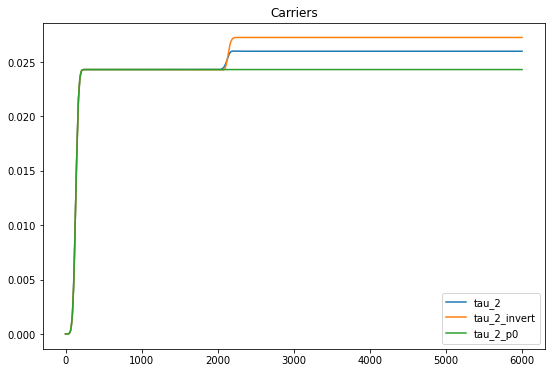

In [22]:
plt.figure(figsize=(9,6))
for ind,r in results.items():
    t = r.data['carriers']['time']
    dne = r.data['carriers']['dne']
    print(dne[-1])
    plt.plot(t,dne,label=D.name_from_id(study.ids[ind]))
    plt.title('Carriers')
    plt.legend()
    #plt.show()

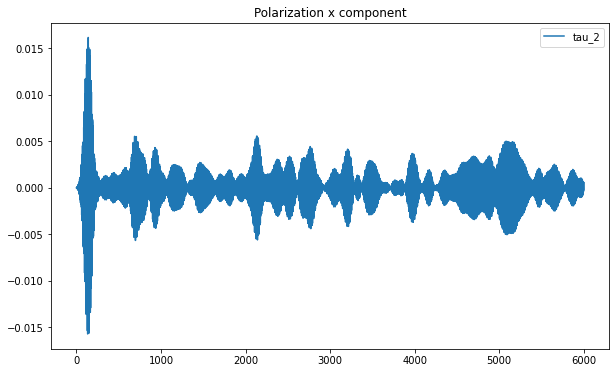

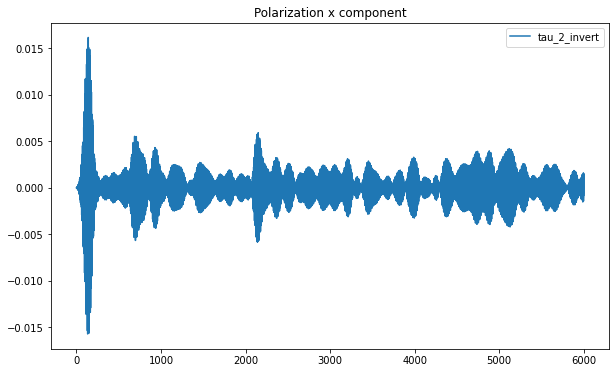

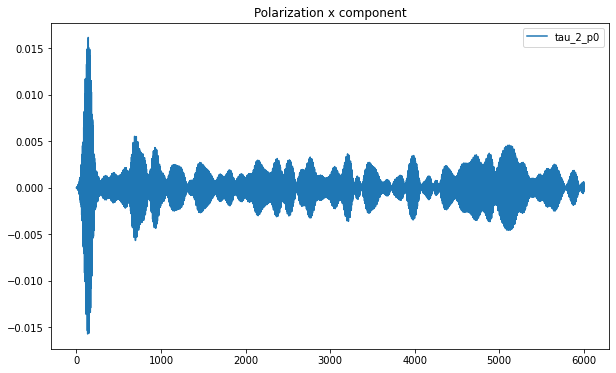

In [24]:
for ind,r in results.items():
    plt.figure(figsize=(10,6))
    t = r.data['polarization']['time']
    dne = r.data['polarization']['Pol_x']
    plt.plot(t,dne,label=D.name_from_id(study.ids[ind]))
    plt.title('Polarization x component')
    plt.legend()
    plt.show()

### Observables from the density matrix

We check that the observables reported in output files can be obtained from the density matrix

In [25]:
study.ids

['tau_2', 'tau_2_invert', 'tau_2_p0']

In [30]:
sim = 0

In [45]:
green = results[sim].RTGreen
dm0 = green.buildEqDensityMatrix(num_occupied_bands=3)
dm = green.buildDensityMatrix(equilibrium_dm=dm0)
ntimes = len(dm) # dimension of the time index
nk = len(dm[0]) # dimension of the index
dm.shape

(2401, 1183, 4, 4)

We define a time variable that convert the time index of the density matrix in
the effective simulation time

In [47]:
time_dm = np.linspace(0,NETime,ntimes)
time_dm.shape

(2401,)

In [48]:
time_dm

array([0.0000e+00, 2.5000e+00, 5.0000e+00, ..., 5.9950e+03, 5.9975e+03,
       6.0000e+03])

From the dm we can compute the number of carriers in function of time

In [49]:
trace_cc = np.trace(dm[:,:,3:,3:],axis1=2,axis2=3) #trace in the conduction sector
carriers = np.mean(trace_cc,axis=1) # average over k

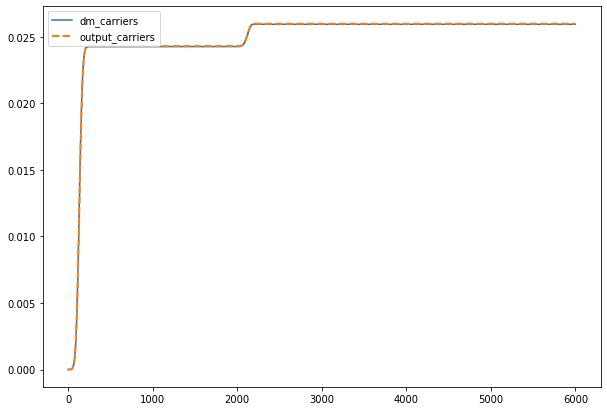

In [50]:
plt.figure(figsize=(10,7))
plt.plot(time_dm,carriers.real,label='dm_carriers')
t = results[sim].data['carriers']['time']
dne = results[sim].data['carriers']['dne']
plt.plot(t,dne,label='output_carriers',linestyle='--',linewidth=2)
plt.legend()

We can compute also the expectation value of the polarization and compare it with the one
provided in the output files (it has to be rescaled with the lattice volume).

In [51]:
x_dipole = results[sim].dipoles.r_dipole(0)

In [52]:
dft = results[sim].dft
lat_vol = dft.eval_lattice_volume()
lat_vol

294.0614899039999

In [76]:
Polx = -np.mean(np.trace(np.matmul(dm,x_dipole),axis1=2,axis2=3),axis=1)
Polx = Polx.real/lat_vol

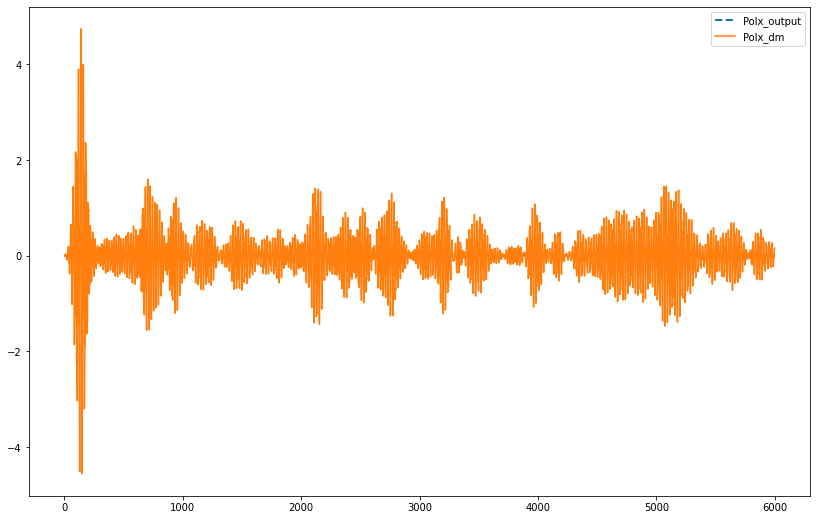

In [75]:
plt.figure(figsize=(14,9))
t = results[sim].data['polarization']['time']
Polx_out = results[sim].data['polarization']['Pol_x']
plt.plot(t,Polx_out,label='Polx_output',linestyle='--',linewidth=2)
plt.plot(time_dm,Polx.real,label='Polx_dm')
#plt.xlim(500,1000)
plt.legend()

### Extraction of the echo signal

In [62]:
sim = 0
green = results[sim].RTGreen
dm0 = green.buildEqDensityMatrix(num_occupied_bands=3)
dm = green.buildDensityMatrix(equilibrium_dm=dm0)

sim = 1
green = results[sim].RTGreen
dm0 = green.buildEqDensityMatrix(num_occupied_bands=3)
dm_invert = green.buildDensityMatrix(equilibrium_dm=dm0)

sim = 2
green = results[sim].RTGreen
dm0 = green.buildEqDensityMatrix(num_occupied_bands=3)
dm_p0 = green.buildDensityMatrix(equilibrium_dm=dm0)

In [64]:
dm.shape,dm_invert.shape,dm_p0.shape

((2401, 1183, 4, 4), (2401, 1183, 4, 4), (2401, 1183, 4, 4))

In [68]:
dm_echo = 0.5*(dm+dm_invert)-dm_p0

In [67]:
dm_echo.shape

(2401, 1183, 4, 4)

In [77]:
Polx_echo = -np.mean(np.trace(np.matmul(dm_echo,x_dipole),axis1=2,axis2=3),axis=1)
#Polx_echo = Polx_echo.real/lat_vol

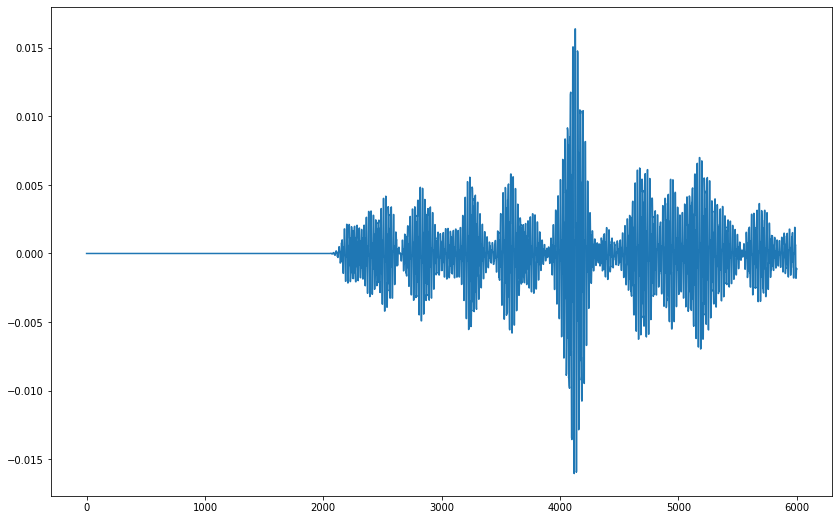

In [78]:
plt.figure(figsize=(14,9))
plt.plot(time_dm,Polx_echo.real,label='Polx_dm')

Note the (apart from the lattice volume) the height of the peak is similar to twice the value obtained in the TLS
(and the factor 2 can be due to spin degeneracy....to be checked)....